In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from sklearn import metrics

In [2]:
class my_Dataset(Data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

class WheelRailTrajectoryDataset:
    def __init__(self,label=3):
        standard_scaler = StandardScaler()
        self.raw_data1 = pd.read_csv("../dataset/curve_R400.csv")
        self.raw_data2 = pd.read_csv("../dataset/curve_R1000.csv")
        self.raw_data3 = pd.read_csv("../dataset/curve_R2000.csv")
        self.raw_data4 = pd.read_csv("../dataset/curve_R3000.csv")
        self.raw_data5 = pd.read_csv("../dataset/curve_R4000.csv")
        self.raw_data6 = pd.read_csv("../dataset/curve_R5000.csv")
        self.raw_data = pd.concat([self.raw_data1,self.raw_data2,self.raw_data3,self.raw_data4,self.raw_data5,self.raw_data6])
        self.label = label
        #标准化
        self.data = standard_scaler.fit_transform(self.raw_data)
        self.mean = standard_scaler.mean_[label]
        self.sd = math.sqrt(standard_scaler.var_[label])


    def construct_set(self, train_por=0.6,val_por=0.2,test_por=0.2, window_size=100):
        X = []
        Y = []
        list = [self.raw_data1.shape[0],self.raw_data2.shape[0],self.raw_data3.shape[0],self.raw_data4.shape[0],self.raw_data5.shape[0],self.raw_data6.shape[0]]
        num = 0
        for j in range(len(list)):
            if j!=0:
                num = num+list[j-1]
            for i in range(list[j]-window_size):
                seq = self.data[num+i:num+i+window_size+1]
                X.append(seq[0:window_size,:self.label])
                y = seq[window_size:window_size+1,self.label]
                if(y>0.6 or y<-0.6):
                    Y.append(1)
                else:
                    Y.append(0)
        X = np.array(X)
        Y = np.array(Y)
        print(X.shape)
        print(Y.shape)
        train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=test_por,train_size=train_por+val_por,shuffle=True)
        train_x,val_x,train_y,val_y =  train_test_split(train_x,train_y,test_size=val_por/(val_por+train_por),train_size=train_por/(val_por+train_por),shuffle=True)

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

TrajectoryData = WheelRailTrajectoryDataset()
train_set, val_set, test_set = TrajectoryData.construct_set()
batch_size = 256
train_loader = Data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

(227406, 100, 3)
(227406,)


In [3]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model,seq_len = 100):
        super(PositionalEncoding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(seq_len, d_model+1)
        #维数 seq_len X d_model
        position = torch.arange(0, seq_len).unsqueeze(1) #  维数 seq_lenX1
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        #维数 dmodel/2
        pe[:, 0::2] = torch.sin(position * div_term)
        #维数 seq_len X dmodel/2
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        #维数 1Xseq_lenXd_model
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x batch_size X seq_len X num_features
        #print("x:",x.shape)
        #print("pe:",self.pe.shape)
        x = x + Variable(self.pe[:,:,:x.shape[-1]], requires_grad=False)
        return x

In [4]:
class Splitting(nn.Module):
    # B D L 
    def __init__(self):
        super(Splitting, self).__init__()

    def even(self, x):
        return x[:, :, ::2]

    def odd(self, x):
        return x[:, :, 1::2]

    def forward(self, x):
        '''Returns the odd and even part'''
        return (self.even(x), self.odd(x))

In [5]:
class SampleIsometricConvBlock(nn.Module):
    def __init__(self,variable_dim,ffn_dim,seq_len):
        super(SampleIsometricConvBlock, self).__init__()
        self.A = nn.Conv1d(in_channels=variable_dim, out_channels=variable_dim,
                           kernel_size=seq_len//2,padding=0,stride=1,groups=variable_dim)
        self.B = nn.Conv1d(in_channels=variable_dim, out_channels=variable_dim,
                           kernel_size=seq_len//2,padding=0,stride=1,groups=variable_dim)
        self.C = nn.Conv1d(in_channels=variable_dim, out_channels=variable_dim,
                           kernel_size=seq_len//2,padding=0,stride=1,groups=variable_dim)
        self.D = nn.Conv1d(in_channels=variable_dim, out_channels=variable_dim,
                           kernel_size=seq_len//2,padding=0,stride=1,groups=variable_dim)
        self.ffn = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim, out_channels=ffn_dim,padding='same',kernel_size=1),
            nn.GELU(),
            nn.Conv1d(in_channels=ffn_dim, out_channels=variable_dim,padding='same',kernel_size=1),
            nn.Tanh()
        )
        self.norm_1 = nn.LayerNorm(variable_dim)
        self.norm_2 = nn.LayerNorm(variable_dim)
        self.split = Splitting()
        
    def conv(self,x,conv_module):
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1),device='cuda')
        x = torch.cat((zeros, x), dim=-1)
        out = conv_module(x)
        return out
    
    def forward(self,x):
        #B L D
        residual = x
        x  = x.permute(0,2,1)
        start_even, start_odd = self.split(x)
        mid_odd = start_odd.mul(torch.exp(self.conv(start_even,self.A)))
        mid_even = start_even.mul(torch.exp(self.conv(start_odd,self.B)))
        end_odd = mid_odd - self.conv(mid_even,self.C)
        end_even = mid_even - self.conv(mid_odd,self.D)
        # batch_size feature seq_len
        y = torch.zeros((x.shape[0], x.shape[1], x.shape[2]),device='cuda')
        y[:,:,1::2] = end_odd
        y[:,:,::2] = end_even
        y = y.permute(0,2,1)
        y = self.norm_1(y + residual)
        residual = y
        y = y.permute(0,2,1)
        z = self.ffn(y)
        z = z.permute(0,2,1)
        out = self.norm_2(z + residual)
        return out        

In [9]:
class SICNet(nn.Module):
    def __init__(self,num_i,feature_dim,mlp_dim,seq_len):
        super(SICNet,self).__init__()
        self.pe = PositionalEncoding(3)
        self.IsometricConvList = nn.ModuleList([SampleIsometricConvBlock(feature_dim,mlp_dim,seq_len) for _ in range(num_i)])
        self.channel_interaction = nn.Sequential(
            nn.Linear(in_features=feature_dim,out_features=feature_dim*16),
            nn.GELU(),
            nn.Linear(in_features=feature_dim*16,out_features=1),
            nn.Dropout(0.1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=seq_len,out_features=seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        self.norm = nn.LayerNorm(feature_dim)

    def forward(self,x):
        x = x+self.pe(x)
        residual = x
        for Iblock in self.IsometricConvList:
            i_features = Iblock(x)
        i_features = self.norm(i_features+residual)
        y = self.channel_interaction(i_features).squeeze()
        y = self.classifier(y)
        return y

In [7]:
def evaluate_accuracy(data_iter, net, loss,device="cuda"):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        l = loss(y_hat, y.long()).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"../weights/SICNet_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy


def visualization(train_loss,val_loss,train_accuracy,val_accuracy):
    plt.figure(1)
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(2)
    x2 = np.linspace(0,len(train_accuracy),len(train_accuracy))
    plt.plot(x2,train_accuracy,label='train_accuracy',linewidth=1.5)
    plt.plot(x2,val_accuracy,label='val_accuracy',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

In [12]:
device = torch.device("cuda")
lr = 0.0001
epochs=150
loss=nn.CrossEntropyLoss()
net = SICNet(3,3,32,100)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

In [13]:
train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)

epoch1,loss0.0023,train acc 0.687654,val acc 0.778
epoch2,loss0.0020,train acc 0.788189,val acc 0.799
epoch3,loss0.0019,train acc 0.802052,val acc 0.814
epoch4,loss0.0019,train acc 0.818110,val acc 0.829
epoch5,loss0.0018,train acc 0.828712,val acc 0.837
epoch6,loss0.0018,train acc 0.835857,val acc 0.845
epoch7,loss0.0018,train acc 0.838449,val acc 0.849
epoch8,loss0.0018,train acc 0.842759,val acc 0.843
epoch9,loss0.0018,train acc 0.831392,val acc 0.850
epoch10,loss0.0018,train acc 0.845094,val acc 0.847
epoch11,loss0.0018,train acc 0.845321,val acc 0.854
epoch12,loss0.0018,train acc 0.847039,val acc 0.829
epoch13,loss0.0018,train acc 0.847282,val acc 0.851
epoch14,loss0.0018,train acc 0.849169,val acc 0.857
epoch15,loss0.0018,train acc 0.850131,val acc 0.848
epoch16,loss0.0018,train acc 0.849396,val acc 0.858
epoch17,loss0.0018,train acc 0.852099,val acc 0.861
epoch18,loss0.0018,train acc 0.853677,val acc 0.862
epoch19,loss0.0018,train acc 0.850968,val acc 0.857
epoch20,loss0.0018,tr

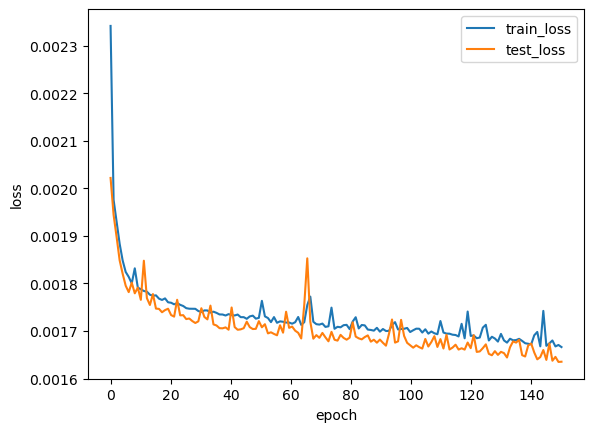

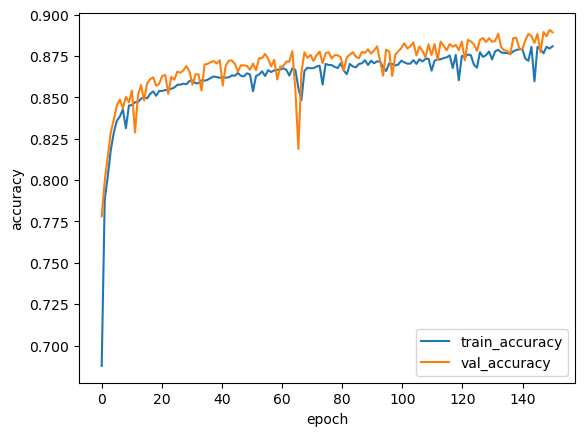

In [14]:
visualization(train_loss,val_loss,train_accuracy,val_accuracy)

In [15]:
net.load_state_dict(torch.load("../weights/SICNet_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test dataset :%.3f"%(test_acc))

Accuracy on test dataset :0.883


In [16]:
def evaluate_PR(data_iter, net, loss,device="cuda"):
    n = 0
    precision_sum,recall_sum,f1_score_sum = 0.0,0.0,0.0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y.long()).sum()
        y_hat = y_hat.argmax(dim=1)
        y_hat = y_hat.squeeze().cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        precision_sum += metrics.precision_score(y,y_hat)
        recall_sum += metrics.recall_score(y,y_hat)
        f1_score_sum += metrics.f1_score(y,y_hat)
        test_l_sum += l.item()
        #n += y.shape[0]
        n+=1
    return precision_sum/n,recall_sum/n,f1_score_sum/n
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

test precision: 0.8593959889772964  test recall: 0.8571963103554618  test f1_score: 0.8577531669348042
